In [1]:
import pandas as pd
import numpy as np
from numba import jit
import torch
import time, math
from matplotlib import pyplot

In [2]:
apple_df = pd.read_csv("./data/yahoo/AAPL.csv")
apple_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.296661,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.916723,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,17.008965,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.887323,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,16.994268,258529600


## Feature engineering

### Change in Percent

In [3]:
features = [column for column in apple_df.columns if column not in ['Date']]
label_feature = ['Adj Close']

@jit(nopython=True)
def calc_percent_diff(new_value, old_value):
    diff = abs(new_value - old_value)
    sum = new_value + old_value
    return diff / (sum / 2) * 100

@jit(nopython=True)
def get_percent_change(*features):
    res = np.empty((len(features), features[0].shape[0]))
    res[:, 0] = [feature[0] for feature in features]
    for i in range(1, res.shape[1]):
        res[:, i] = [calc_percent_diff(feature[i], feature[i - 1]) for feature in features]
    return res

In [4]:
percent_change = get_percent_change(*apple_df[features].values.T)
d = {features[i]: percent_change[i] for i in range(len(features))}
res_df = pd.DataFrame(data=d)
## remove first row
res_df = res_df.iloc[1:]
## reorder such that adj close to be the last column
cols = res_df.columns.tolist()
cols = cols[:-2] + cols[-1:] + [cols[-2]]
res_df = res_df[cols]
res_df.head()

,Open,High,Low,Close,Volume,Adj Close
1,0.508774,0.599607,2.121838,2.220978,50.317212,2.220991
2,2.826722,1.253980,1.271847,0.543819,5.004034,0.543784
3,1.270142,0.153733,0.806340,0.717726,26.143871,0.717726
4,1.017428,0.073294,0.143042,0.631287,20.384105,0.631287
5,1.471980,0.238004,0.621960,1.285214,7.669715,1.285157


### Train, Test, Validation Split
60%, 20%, 20% split

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(res_df, test_size=0.2, random_state=1, shuffle=False)

train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=1, shuffle=False) # 0.25 x 0.8 = 0.2

In [7]:
train_data.shape

(1528, 6)

In [8]:
test_data.shape

(510, 6)

In [9]:
val_data.shape

(510, 6)

### Normalization

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
norm_train = scaler.fit_transform(train_data)
norm_val = scaler.transform(val_data)
norm_test = scaler.transform(test_data)

### Preprocessing

In [5]:
def create_inout_sequences(input_data, input_window ,output_window):
    inout_seq = []
    L = len(input_data)
    block_len = input_window_size + output_window_size
    block_num =  L - block_len + 1
    # total of [N - block_len + 1] blocks
    # where block_len = input_window + output_window

    for i in range( block_num ):
        train_seq = input_data[i : i + input_window]
        train_label = input_data[i + output_window : i + input_window + output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(np.array(inout_seq))

In [6]:
input_window_size = 30 # window size of an input
output_window_size = 1 # window size of an output

inout_sequences = create_inout_sequences(res_df, input_window_size, output_window_size)

In [7]:
inout_sequences.shape # block_size, 2 (input, output), seq_len, num_features

torch.Size([2518, 2, 30, 6])

### Train, Test, Validation Split
60%, 20%, 20% split

In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(inout_sequences, test_size=0.2, random_state=1, shuffle=True)

train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=1, shuffle=True) # 0.25 x 0.8 = 0.2

In [9]:
train_data.shape

torch.Size([1510, 2, 30, 6])

In [10]:
test_data.shape

torch.Size([504, 2, 30, 6])

In [11]:
val_data.shape

torch.Size([504, 2, 30, 6])

In [12]:
stacked_train_data = train_data.reshape(-1, train_data.shape[-1])
stacked_test_data = test_data.reshape(-1, test_data.shape[-1])
stacked_val_data = val_data.reshape(-1, val_data.shape[-1])

In [13]:
print(stacked_train_data.shape, stacked_test_data.shape, stacked_val_data.shape)

torch.Size([90600, 6]) torch.Size([30240, 6]) torch.Size([30240, 6])


In [14]:
np.array_equal(train_data, stacked_train_data.reshape(train_data.shape))

True

### Normalization

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # MinMaxScaler(feature_range=(-1, 1))
norm_stacked_train = scaler.fit_transform(stacked_train_data)
norm_stacked_val = scaler.transform(stacked_val_data)
norm_stacked_test = scaler.transform(stacked_test_data)

In [16]:
norm_train_seq =  torch.FloatTensor(norm_stacked_train.reshape(train_data.shape))
norm_val_seq =  torch.FloatTensor(norm_stacked_val.reshape(val_data.shape))
norm_test_seq =  torch.FloatTensor(norm_stacked_test.reshape(test_data.shape))

In [17]:
print(norm_train_seq.shape, norm_val_seq.shape, norm_test_seq.shape)

torch.Size([1510, 2, 30, 6]) torch.Size([504, 2, 30, 6]) torch.Size([504, 2, 30, 6])


## Model
This model predicts the closed price in the future :)

In [18]:
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)
          

class TransAm(nn.Module):
    def __init__(self, input_feature_num, output_feature_num, pos_feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(input_feature_num, pos_feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(pos_feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=pos_feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(pos_feature_size, output_feature_num)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [19]:
def get_batch(input_data, i , batch_size):
    # batch_len = min(batch_size, len(input_data) - 1 - i) #  # Now len-1 is not necessary
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[ i:i + batch_len ]
    input = torch.stack([item[0] for item in data]).view((-1,batch_len,6))
    # ( seq_len, batch, 6 ) , 6 is feature size
    target = torch.stack([item[1] for item in data]).view((-1,batch_len,6))
    return input, target
    
def train(train_data):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data), batch_size)):  # Now len-1 is not necessary
        # data and target are the same shape with (input_window,batch_len,1)
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        output = model(data)
        # NOTE: just compare next day
        loss = criterion(output, targets[:, :, -1:])
        # loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [20]:
def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(len(data_source)):
            data, target = get_batch(data_source, i , 1) # one-step forecast
            output = eval_model(data)
            # total_loss += criterion(output, target).item()
            # NOTE: just compare next day
            total_loss += criterion(output, target[:, :, -1:]).item()
            test_result = torch.cat((test_result, output[-1, :, -1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1, :, -1].view(-1).cpu()), 0)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i

def predict(eval_model, data_source, input_window, epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, targets = get_batch(data_source, 0 , 1)
    with torch.no_grad():
        output = eval_model(data[-input_window:])

    output = output[-1:].cpu().view(-1)
    target = targets[-1, :, -1].cpu().view(-1)
    
    fig, ax = pyplot.subplots()
    x_vals = ['true', 'predicted']
    y_vals = [target.item(), output.item()]
    bar_labels = ['true', 'predicted']
    bar_colors = ['tab:blue', 'tab:red']
    
    ax.bar(x_vals, y_vals, label=bar_labels, color=bar_colors)
    
    ax.set_ylabel('change in adj close')
    ax.set_title('True vs Predicted Change in Adj Close')
    ax.legend(title='true vs predicted')

    pyplot.savefig('graph/transformer-predict%d.png'%epoch)
    pyplot.show()
    pyplot.close()

# predict the next n steps based on the input data 
# def predict_future(eval_model, data_source, steps, input_window):
#     eval_model.eval() 
#     total_loss = 0.
#     test_result = torch.Tensor(0)    
#     truth = torch.Tensor(0)
#     data, _ = get_batch(data_source, 0 , 1)
#     with torch.no_grad():
#         for i in range(0, steps):            
#             output = eval_model(data[-input_window:])
#             # (seq-len , batch-size , features-num)
#             # input : [ m,m+1,...,m+n ] -> [m+1,...,m+n+1]
#             # print(data.shape)
#             # print(output[-1:].shape)
#             data = torch.cat((data, output[-1:])) 

#     data = data.cpu().view(-1)
#     print(data.shape)

#     # I used this plot to visualize if the model pics up any long therm structure within the data.
#     pyplot.plot(data,color="red")       
#     pyplot.plot(data[:input_window],color="blue")    
#     pyplot.grid(True, which='both')
#     pyplot.axhline(y=0, color='k')
#     pyplot.savefig('graph/transformer-future%d.png'%steps)
#     pyplot.show()
#     pyplot.close()
        

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)        
            # total_loss += len(data[0]) * criterion(output, targets).cpu().item()
            # NOTE: just compare next day
            total_loss += len(data[0]) * criterion(output, targets[:, :, -1:]).cpu().item()
    return total_loss / len(data_source)

/home/jaewookahn/miniconda3/envs/port_comp/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/jaewookahn/miniconda3/envs/port_comp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |    30/  151 batches | lr 0.005000 | 26.86 ms | loss 11.29880 | ppl 80724.43
| epoch   1 |    60/  151 batches | lr 0.005000 |  3.10 ms | loss 1.11479 | ppl     3.05
| epoch   1 |    90/  151 batches | lr 0.005000 |  3.00 ms | loss 1.10902 | ppl     3.03
| epoch   1 |   120/  151 batches | lr 0.005000 |  2.94 ms | loss 1.00707 | ppl     2.74
| epoch   1 |   150/  151 batches | lr 0.005000 |  2.91 ms | loss 1.01019 | ppl     2.75
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  1.18s | valid loss 1.33634 | valid ppl     3.81
-----------------------------------------------------------------------------------------
| epoch   2 |    30/  151 batches | lr 0.004513 |  2.99 ms | loss 1.26862 | ppl     3.56
| epoch   2 |    60/  151 batches | lr 0.004513 |  2.96 ms | loss 1.00155 | ppl     2.72
| epoch   2 |    90/  151 batches | lr 0.004513 |  3.01 ms | loss 0.91225 | ppl     2.49
| epoch   2 |   120/  151 batch

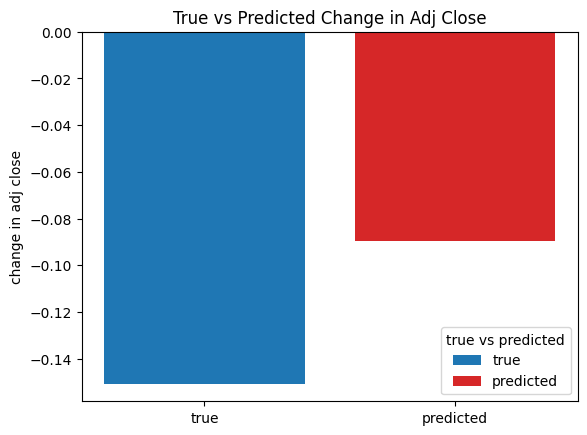

-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  0.95s | valid loss 1.02822 | valid ppl     2.80
-----------------------------------------------------------------------------------------
| epoch  11 |    30/  151 batches | lr 0.002844 |  3.80 ms | loss 1.05576 | ppl     2.87
| epoch  11 |    60/  151 batches | lr 0.002844 |  3.04 ms | loss 1.05605 | ppl     2.87
| epoch  11 |    90/  151 batches | lr 0.002844 |  3.05 ms | loss 0.90060 | ppl     2.46
| epoch  11 |   120/  151 batches | lr 0.002844 |  3.17 ms | loss 0.89458 | ppl     2.45
| epoch  11 |   150/  151 batches | lr 0.002844 |  3.31 ms | loss 0.91853 | ppl     2.51
-----------------------------------------------------------------------------------------
| end of epoch  11 | time:  0.50s | valid loss 1.09711 | valid ppl     3.00
-----------------------------------------------------------------------------------------
| epoch  12 |    30/  151 batches | lr 0.00

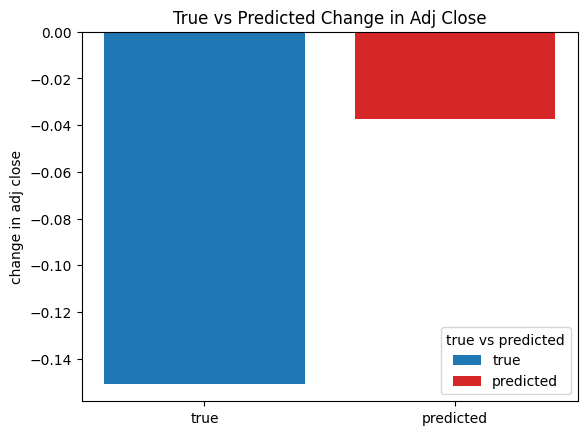

-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  0.84s | valid loss 1.05445 | valid ppl     2.87
-----------------------------------------------------------------------------------------
| epoch  21 |    30/  151 batches | lr 0.001703 |  3.30 ms | loss 1.05527 | ppl     2.87
| epoch  21 |    60/  151 batches | lr 0.001703 |  2.29 ms | loss 0.98935 | ppl     2.69
| epoch  21 |    90/  151 batches | lr 0.001703 |  2.50 ms | loss 0.82799 | ppl     2.29
| epoch  21 |   120/  151 batches | lr 0.001703 |  2.27 ms | loss 0.91267 | ppl     2.49
| epoch  21 |   150/  151 batches | lr 0.001703 |  2.31 ms | loss 1.00301 | ppl     2.73
-----------------------------------------------------------------------------------------
| end of epoch  21 | time:  0.39s | valid loss 1.09775 | valid ppl     3.00
-----------------------------------------------------------------------------------------
| epoch  22 |    30/  151 batches | lr 0.00

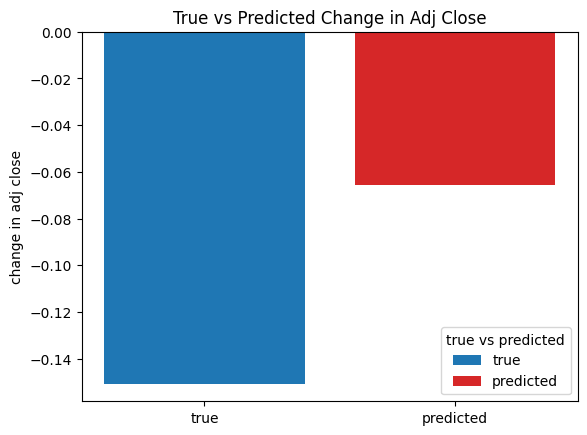

-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  0.89s | valid loss 1.04803 | valid ppl     2.85
-----------------------------------------------------------------------------------------
| epoch  31 |    30/  151 batches | lr 0.001020 |  3.12 ms | loss 1.00700 | ppl     2.74
| epoch  31 |    60/  151 batches | lr 0.001020 |  2.56 ms | loss 0.92948 | ppl     2.53
| epoch  31 |    90/  151 batches | lr 0.001020 |  2.85 ms | loss 0.94814 | ppl     2.58
| epoch  31 |   120/  151 batches | lr 0.001020 |  2.47 ms | loss 0.97893 | ppl     2.66
| epoch  31 |   150/  151 batches | lr 0.001020 |  2.60 ms | loss 0.83554 | ppl     2.31
-----------------------------------------------------------------------------------------
| end of epoch  31 | time:  0.42s | valid loss 1.06579 | valid ppl     2.90
-----------------------------------------------------------------------------------------
| epoch  32 |    30/  151 batches | lr 0.00

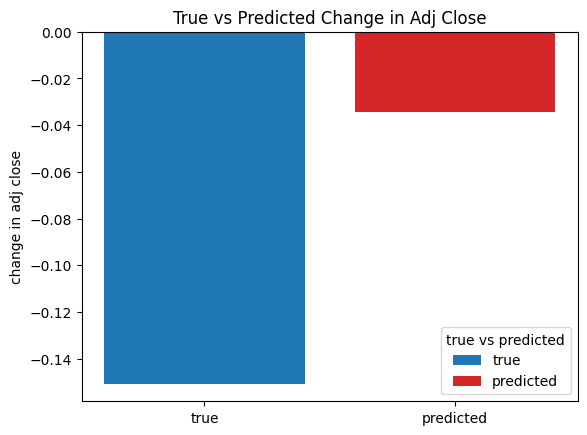

-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  0.87s | valid loss 1.03682 | valid ppl     2.82
-----------------------------------------------------------------------------------------
| epoch  41 |    30/  151 batches | lr 0.000610 |  3.30 ms | loss 0.91491 | ppl     2.50
| epoch  41 |    60/  151 batches | lr 0.000610 |  2.78 ms | loss 1.01104 | ppl     2.75
| epoch  41 |    90/  151 batches | lr 0.000610 |  2.59 ms | loss 0.94055 | ppl     2.56
| epoch  41 |   120/  151 batches | lr 0.000610 |  2.70 ms | loss 0.89156 | ppl     2.44
| epoch  41 |   150/  151 batches | lr 0.000610 |  2.77 ms | loss 0.91069 | ppl     2.49
-----------------------------------------------------------------------------------------
| end of epoch  41 | time:  0.44s | valid loss 1.05035 | valid ppl     2.86
-----------------------------------------------------------------------------------------
| epoch  42 |    30/  151 batches | lr 0.00

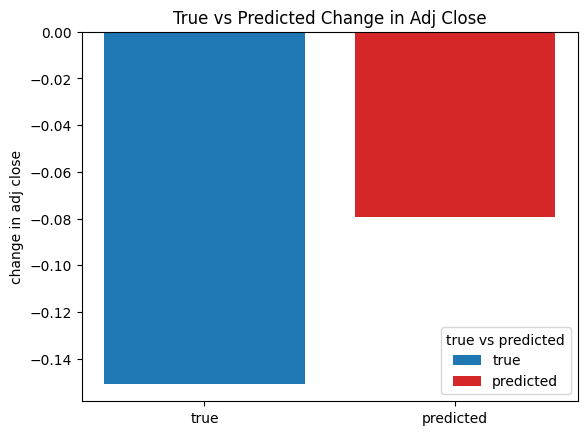

-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  0.88s | valid loss 1.02383 | valid ppl     2.78
-----------------------------------------------------------------------------------------
| epoch  51 |    30/  151 batches | lr 0.000365 |  3.04 ms | loss 0.98108 | ppl     2.67
| epoch  51 |    60/  151 batches | lr 0.000365 |  2.76 ms | loss 0.85634 | ppl     2.35
| epoch  51 |    90/  151 batches | lr 0.000365 |  2.40 ms | loss 0.95235 | ppl     2.59
| epoch  51 |   120/  151 batches | lr 0.000365 |  2.95 ms | loss 1.00446 | ppl     2.73
| epoch  51 |   150/  151 batches | lr 0.000365 |  3.05 ms | loss 0.84473 | ppl     2.33
-----------------------------------------------------------------------------------------
| end of epoch  51 | time:  0.44s | valid loss 1.02682 | valid ppl     2.79
-----------------------------------------------------------------------------------------
| epoch  52 |    30/  151 batches | lr 0.00

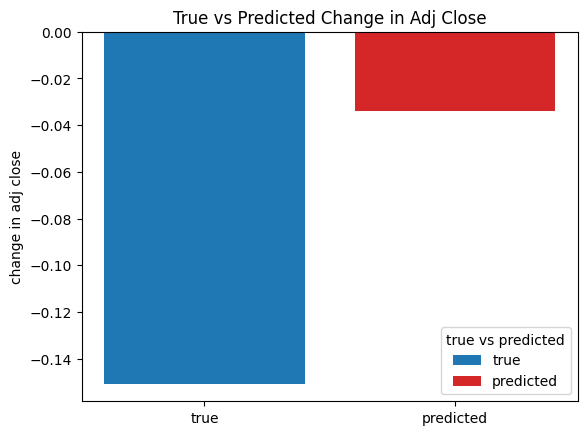

-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  0.90s | valid loss 1.01121 | valid ppl     2.75
-----------------------------------------------------------------------------------------
| epoch  61 |    30/  151 batches | lr 0.000219 |  2.66 ms | loss 0.85667 | ppl     2.36
| epoch  61 |    60/  151 batches | lr 0.000219 |  2.60 ms | loss 0.94459 | ppl     2.57
| epoch  61 |    90/  151 batches | lr 0.000219 |  2.72 ms | loss 0.93161 | ppl     2.54
| epoch  61 |   120/  151 batches | lr 0.000219 |  2.55 ms | loss 0.93035 | ppl     2.54
| epoch  61 |   150/  151 batches | lr 0.000219 |  2.84 ms | loss 0.97072 | ppl     2.64
-----------------------------------------------------------------------------------------
| end of epoch  61 | time:  0.41s | valid loss 1.02814 | valid ppl     2.80
-----------------------------------------------------------------------------------------
| epoch  62 |    30/  151 batches | lr 0.00

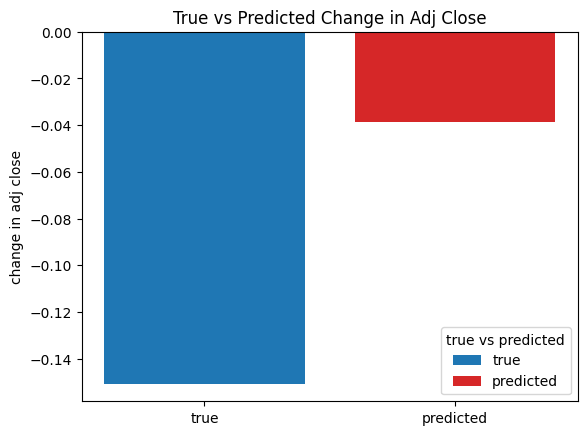

-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  0.94s | valid loss 1.01930 | valid ppl     2.77
-----------------------------------------------------------------------------------------
| epoch  71 |    30/  151 batches | lr 0.000131 |  2.75 ms | loss 1.01439 | ppl     2.76
| epoch  71 |    60/  151 batches | lr 0.000131 |  2.65 ms | loss 0.90266 | ppl     2.47
| epoch  71 |    90/  151 batches | lr 0.000131 |  2.80 ms | loss 0.89837 | ppl     2.46
| epoch  71 |   120/  151 batches | lr 0.000131 |  2.49 ms | loss 0.87833 | ppl     2.41
| epoch  71 |   150/  151 batches | lr 0.000131 |  3.04 ms | loss 0.91691 | ppl     2.50
-----------------------------------------------------------------------------------------
| end of epoch  71 | time:  0.42s | valid loss 1.02219 | valid ppl     2.78
-----------------------------------------------------------------------------------------
| epoch  72 |    30/  151 batches | lr 0.00

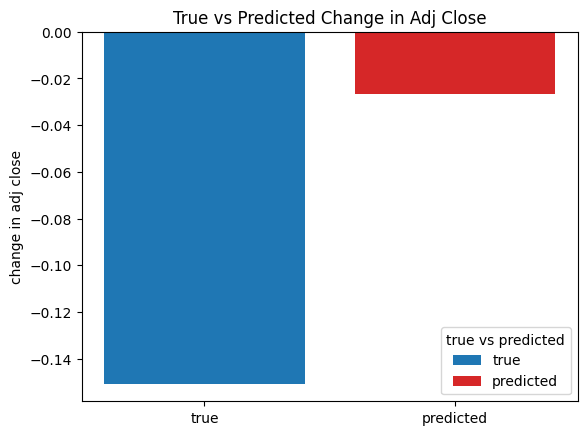

-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  0.96s | valid loss 1.01939 | valid ppl     2.77
-----------------------------------------------------------------------------------------
| epoch  81 |    30/  151 batches | lr 0.000078 |  3.34 ms | loss 1.00667 | ppl     2.74
| epoch  81 |    60/  151 batches | lr 0.000078 |  3.03 ms | loss 0.90155 | ppl     2.46
| epoch  81 |    90/  151 batches | lr 0.000078 |  2.61 ms | loss 0.95860 | ppl     2.61
| epoch  81 |   120/  151 batches | lr 0.000078 |  2.66 ms | loss 0.89576 | ppl     2.45
| epoch  81 |   150/  151 batches | lr 0.000078 |  2.95 ms | loss 0.84352 | ppl     2.32
-----------------------------------------------------------------------------------------
| end of epoch  81 | time:  0.45s | valid loss 1.02351 | valid ppl     2.78
-----------------------------------------------------------------------------------------
| epoch  82 |    30/  151 batches | lr 0.00

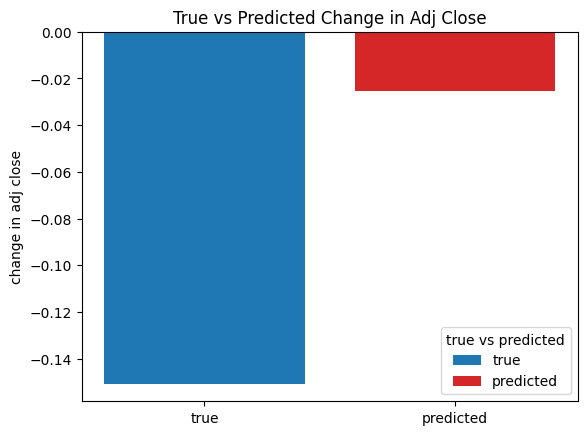

-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  0.97s | valid loss 1.01661 | valid ppl     2.76
-----------------------------------------------------------------------------------------
| epoch  91 |    30/  151 batches | lr 0.000047 |  2.70 ms | loss 0.98443 | ppl     2.68
| epoch  91 |    60/  151 batches | lr 0.000047 |  2.61 ms | loss 0.88104 | ppl     2.41
| epoch  91 |    90/  151 batches | lr 0.000047 |  2.73 ms | loss 0.95127 | ppl     2.59
| epoch  91 |   120/  151 batches | lr 0.000047 |  2.50 ms | loss 0.93549 | ppl     2.55
| epoch  91 |   150/  151 batches | lr 0.000047 |  2.65 ms | loss 0.88245 | ppl     2.42
-----------------------------------------------------------------------------------------
| end of epoch  91 | time:  0.41s | valid loss 1.02295 | valid ppl     2.78
-----------------------------------------------------------------------------------------
| epoch  92 |    30/  151 batches | lr 0.00

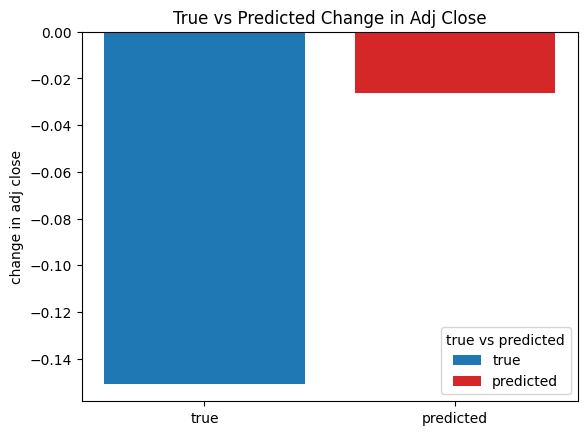

-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  1.02s | valid loss 1.01479 | valid ppl     2.76
-----------------------------------------------------------------------------------------


In [21]:
batch_size = 10
train_size = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransAm(len(features), len(label_feature)).to(device) # 6, 1

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    idx = torch.randperm(len(norm_train_seq)) # shuffle
    epoch_start_time = time.time()
    train(norm_train_seq[idx].to(device))
    if ( epoch % 10 == 0 ):
        val_loss = plot_and_loss(model, norm_val_seq.to(device), epoch)
        predict(model, norm_val_seq.to(device), input_window_size, epoch)
    else:
        val_loss = evaluate(model, norm_val_seq.to(device))
   
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

## Inference
Autoregressive inference

In [22]:
day_in_future = 10 # day in the future to predict
